# T. Gondii Virome Graph

## Overview

### Graph structure

#### Virus nodes

- Only use sOTUs
- All non-centroid palmprints are collapsed into their associated centroid. Centroids aggregate relationships associated to non-centroid palmprints

#### Host nodes

- Only include Taxons with 'order' rank (+ some exceptions)
- All taxons with rank = 'order or rank more specific than order are collapsed to ancestor taxon with a order rank. Any taxons with a missing order ancestor are added directly with display label `Unknown`
- Remove 44,092 unclassified taxons (metagenomic, environmental, children of TaxId '12908') 


#### HAS_HOST edges 

- Edges include SOTUs and Taxons directly associated with SRAs from Toxo dataset
- Edges aggregate count by summing multiple SRA associations, and aggregate weight by averaging `percentIdentity` from non-centroid Palmprints and non-order ranked Taxons
 

#### Nodes of interest
- Toxoplasma gondii has order `Eucoccidiorida` with taxId `75739`
- Palmprints associated to Ruby and Cougar strains can be filtered by using node property `point:isRubyOrCougar` or by palmId `u658323` or `u380516`


### Graph Analysis


#### Community Detection
- Label propagation Algorithm (LPA) nicely clusters communities of Taxons and associated palmprints (`point:communityId`) and can be used to color the Virome
- Transitional palmprints with edges between diffent communities are of interest

#### Centrality
- Centrality algorithms measure the spread of influence of nodes in the network
- Page Rank highlights nodes with high importantance (`point:pageRank`)
- Degree is similarly useful (`point:degree`)
- CELF allows specifying count (seed) of k most important nodes in the network, which typically highlights high degree Taxons (`point:celf`)

#### Transitionary nodes as potential parasites

- Ruby and cougar have Palmprints that are transitionary nodes between clusters, i.e. they have edges between two Taxon families Sarcocystidae, the parent of T Gondii (5809) and Hominidae (9604)
- It may be of interest to analyze other transitionary Palmprint nodes with edges between these and other tax families to understand if they have similar vector/parasitic qualities


#### Fisher's exact test 
- Fisher’s exact test is a statistical test used for testing the association between the two independent categorical variables
- A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis

Viral co-occurrence

|              | (Virus_1, Host_1) | (Virus_1, Host_2) | Row total          |
|--------------|-------------------|-------------------|--------------------|
| T. Gondi     | a                 | b                 | a + b              |
| Not T. Gondi | c                 | d                 | c + d              |
| Column Total | a + c             | b + d             | a + b + c + d (=n) |

Host Co-occurrence

|              | (Virus_1, Host_1) | (Virus_2, Host_1) | Row total          |
|--------------|-------------------|-------------------|--------------------|
| T. Gondi     | a                 | b                 | a + b              |
| Not T. Gondi | c                 | d                 | c + d              |
| Column Total | a + c             | b + d             | a + b + c + d (=n) |


#### Co-occurrence Triangles
- Viral co-occurrence relates taxons by associating a common virus found in two different taxon families
- Host Co-occurrence relates viruses by associating a common host to two different sOTU
- Viral co-ocurrence across hosts shows indication of zoonotic potential, either through parasites or other viral vectors and causal interactions
- Co-occurrence edges form triangles in the network. These triangles can be used in clustering algorithms, i.e. [Local Clustering Coeffecient](https://neo4j.com/docs/graph-data-science/current/algorithms/local-clustering-coefficient/) which describes the likelihood that the neighbours of node $n$ are also connected.
- To compute $C_n$ we use the number of triangles a node is a part of $T_n$, and the degree of the node $d_n$. The formula to compute the local clustering coefficient is as follows:
    $
    {\displaystyle
    C_n = \frac{2 T_n}{d_n(d_n - 1)}
    }
    $

## Setup

### Imports and config

In [2]:
# Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

import collections
import os
import urllib.parse

os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'

import pandas as pd
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import matplotlib.pyplot as plt
import graphistry
from scipy.stats import chi2_contingency


from datasources.neo4j import gds
from queries import utils

/Users/lukepereira/anaconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
graphistry.register(
    api=3,
    username=os.getenv('GRAPHISTRY_USERNAME'),
    password=os.getenv('GRAPHISTRY_PASSWORD'),
)

pandas2ri.activate()

base_data_path = './tgav_data/'
toxo_data_path = base_data_path + 'toxo/'
neo4j_data_path = base_data_path + 'neo4j/'
graphistry_data_path = base_data_path + 'graphistry/'


### Parse SRA csvs

In [4]:
def get_toxo_dfs():
    # Get RunID, TaxID pairs from original datasets
    df1 = pd.read_csv(toxo_data_path + 'toxo_SraRunInfo.csv')
    df2 = pd.read_csv(toxo_data_path + 'txid5810_SraRunInfo.csv')
    df3 = pd.read_csv(toxo_data_path + 'txid5810_statbigquery.csv')
    df3 = df3.rename(columns={'tax_id': 'TaxID', 'acc': 'Run'})
    sra_union = pd.concat([df1[['Run', 'TaxID']], df2[['Run', 'TaxID']], df3[['Run', 'TaxID']]], axis=0)
    sra_union = sra_union.drop_duplicates(subset=['Run'])
    sra_union = sra_union.astype({"Run": str, "TaxID": int})

    # Get additional biosample metadata (missing TaxId)
    sra_union_metadata = pd.read_csv(toxo_data_path + 'tg_set_all_metadata_additional.csv')
    sra_union_metadata = sra_union_metadata.rename(columns={'acc': 'Run'})
    sra_union = sra_union_metadata.merge(
        sra_union,
        left_on='Run',
        right_on='Run',
        how='left',
    ).drop_duplicates(subset=['Run'])

    # Get intersection of original datasets
    sra_intersection = df1[['Run', 'TaxID']].merge(
        df2[['Run', 'TaxID']],
        left_on='Run',
        right_on='Run',
        how='left',
    ).dropna()
    sra_intersection = sra_intersection.merge(
        df3[['Run', 'TaxID']],
        left_on='Run',
        right_on='Run',
        how='left',
    ).dropna()
    sra_intersection = sra_intersection.astype({"Run": str, "TaxID": int, "TaxID_x": int, "TaxID_y": int })

    return sra_union, sra_intersection


sra_union, sra_intersection = get_toxo_dfs()

print(sra_union.shape)
print(sra_union.columns)

print(sra_intersection.shape)
print(sra_intersection.columns)

/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_2714/687670111.py:3: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(toxo_data_path + 'toxo_SraRunInfo.csv')


(32473, 33)
Index(['Run', 'biosample', 'bioproject', 'sample_acc', 'experiment',
       'sra_study', 'organism', 'releasedate', 'loaddate', 'consent',
       'librarysource', 'assay_type', 'librarylayout', 'libraryselection',
       'platform', 'avgspotlen', 'insertsize', 'mbases', 'mbytes',
       'library_name', 'sample_name', 'center_name',
       'geo_loc_name_country_calc', 'geo_loc_name_country_continent_calc',
       'geo_loc_name_sam', 'age', 'sex_val', 'temp_val', 'temp_units',
       'age_val', 'age_units', 'age_seconds', 'TaxID'],
      dtype='object')
(845, 4)
Index(['Run', 'TaxID_x', 'TaxID_y', 'TaxID'], dtype='object')


/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_2714/687670111.py:12: DtypeWarning: Columns (25,26,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  sra_union_metadata = pd.read_csv(toxo_data_path + 'tg_set_all_metadata_additional.csv')


### Neo4j Query definitions

In [5]:
query_sra_union_collections = """
    MATCH (a:Palmprint)<-[b:HAS_PALMPRINT]-(c:SRA)
        -[d:HAS_HOST_STAT]->(e:Taxon)
    WHERE c.runId in $run_ids
    AND NOT e.taxId = '12908'
    AND NOT (e)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    AND NOT (c)-[:HAS_HOST]->(:Taxon {taxId: '12908'})-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    AND NOT (c)-[:HAS_HOST]->(:Taxon)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    RETURN COLLECT(DISTINCT c.runId) as run_ids, 
        COLLECT(DISTINCT a.palmId) as palm_ids, 
        COLLECT(DISTINCT e.taxId) as tax_ids
"""

query_sra_intersection_collections = """
    MATCH (a:Palmprint)<-[b:HAS_PALMPRINT]-(c:SRA)
        -[d:HAS_HOST_STAT]->(e:Taxon)
    WHERE c.runId in $intersection_ids
    AND NOT (e)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    AND NOT (c)-[:HAS_HOST]->(:Taxon {taxId: '12908'})-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    AND NOT (c)-[:HAS_HOST]->(:Taxon)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
    RETURN COLLECT(DISTINCT c.runId) as run_ids, 
        COLLECT(DISTINCT a.palmId) as palm_ids, 
        COLLECT(DISTINCT e.taxId) as tax_ids
"""

query_sotus = """
    MATCH (n:SOTU)<-[r:HAS_SOTU*0..1]-(p:Palmprint)
    WHERE n.palmId in $palm_ids OR p.palmId in $palm_ids
    RETURN
        id(n) as nodeId,
        n.palmId as appId,
        n.palmId as palmId,
        labels(n) as labels,
        n.centroid as centroid,
        CASE WHEN n.palmId in ['u658323', 'u380516'] THEN True ELSE False END AS isRubyOrCougar,
        CASE WHEN n.palmId in $intersection_ids THEN True ELSE False END AS datasetIntersection,
        count(r) as numPalmprints
"""

query_taxons = """
    MATCH (n:Taxon)
    WHERE n.taxId in $tax_ids
    RETURN
        id(n) as nodeId,
        n.taxId as appId,
        n.taxId as taxId,
        labels(n) as labels,
        n.rank as rank,
        n.taxOrder as taxOrder,
        CASE WHEN n.taxId in $intersection_ids THEN True ELSE False END AS datasetIntersection
"""

query_taxons_order = """
    CALL {
        MATCH (t:Taxon)-[:HAS_PARENT*]->(n:Taxon)
        WHERE t.taxId in $tax_ids
        AND n.rank = 'order'
        RETURN n, t
        UNION
        MATCH (n:Taxon)
        WHERE n.taxId in $tax_ids
        AND n.rank = 'order'
        RETURN n, null as t
    }
    WITH n, t
    RETURN
        id(n) as nodeId,
        n.taxId as appId,
        n.taxId as taxId,
        labels(n) as labels,
        n.rank as rank,
        n.taxOrder as taxOrder,
        CASE WHEN (n.taxId in $intersection_ids OR t.taxId in $intersection_ids)
            THEN True ELSE False END AS datasetIntersection
"""

query_direct_has_host_edges = '''
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[:HAS_HOST]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE s.runId in $run_ids
        AND p.palmId in $sotus
        AND t.taxId in $order_tax_ids
        AND not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        RETURN p, t, r, s
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[:HAS_HOST]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE s.runId in $run_ids
        AND p.palmId in $sotus
        AND t.taxId in $order_tax_ids
        AND not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        RETURN p, t, r, s
    }
    WITH p, t, r, s 
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        id(t) as targetNodeId,
        t.taxId as targetAppId,
        'HAS_HOST' as relationshipType,
        count(*) AS directAssociations,
        count(*) AS count,
        avg(r.percentIdentity) as avgPercentIdentity,
        avg(r.percentIdentity) as weight,
        CASE WHEN s.runId in $intersection_ids THEN True ELSE False END AS datasetIntersection,
        'True' as isDirect
'''

query_direct_has_host_stat = '''
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE s.runId in $run_ids
        AND p.palmId in $sotus
        AND t.taxId in $order_tax_ids
        AND not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        AND NOT (s)-[:HAS_HOST]->(:Taxon {taxId: '12908'})
        AND NOT (s)-[:HAS_HOST]->(:Taxon)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        RETURN p, t, r, s, q
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE s.runId in $run_ids
        AND p.palmId in $sotus
        AND t.taxId in $order_tax_ids
        AND not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        AND NOT (s)-[:HAS_HOST]->(:Taxon {taxId: '12908'})
        AND NOT (s)-[:HAS_HOST]->(:Taxon)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
        RETURN p, t, r, s, q
    }
    WITH p, t, r, s, q
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        id(t) as targetNodeId,
        t.taxId as targetAppId,
        'HAS_HOST_STAT' as relationshipType,
        count(*) AS directAssociations,
        count(*) AS count,
        avg(r.percentIdentity) as avgPercentIdentity,
        avg(r.percentIdentity) as weight,
        avg(q.percentIdentity) as avgPercentIdentityStat,
        CASE WHEN s.runId in $intersection_ids THEN True ELSE False END AS datasetIntersection,
        'True' as isDirect
'''

query_indirect_has_host_edges = '''
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE NOT s.runId IN $run_ids
        AND p.palmId IN $sotus
        AND t.taxId IN $order_tax_ids
        RETURN p, t, r, s
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[:HAS_HOST]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE NOT s.runId IN $run_ids
        AND p.palmId IN $sotus
        AND t.taxId IN $order_tax_ids
        RETURN p, t, r, s
    }
    WITH p, t, r, s
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        id(t) as targetNodeId,
        t.taxId as targetAppId,
        'HAS_HOST_INDIRECT' as relationshipType,
        count(*) AS indirectAssociations,
        count(*) AS count,
        avg(r.percentIdentity) as avgPercentIdentity,
        avg(r.percentIdentity) as weight,
        CASE WHEN s.runId in $intersection_ids THEN True ELSE False END AS datasetIntersection,
        'False' as isDirect
'''


### Create Neo4j dataframes

In [6]:
# TODO: issue with partial cached dfs causing some queries to be empty/missing, likely a parsing issue.
# workaround: deleting all cached csvs and refetch all after making updates  

run_ids_union = list(sra_union.Run.unique())
run_ids_intersection = list(sra_intersection.Run.unique())

def _log_df(df):
    namespace = globals()
    var_name = [name for name in namespace if namespace[name] is df]
    print(var_name, df.shape)
    print(df.head())


def fetch_cached_df(query, params, filename, use_cache=True, log=False):
    if os.path.exists(neo4j_data_path + filename) and use_cache:
        df = pd.read_csv(neo4j_data_path + filename)
        df = utils.deserialize_df(df)
    else:
        df = gds.run_cypher(query, params=params)
        df.to_csv(neo4j_data_path + filename, index=False)
    if log:
        _log_df(df)
    return df


def get_neo4j_data():
    union_collections = fetch_cached_df(
        query_sra_union_collections,
        {
            'run_ids': list(run_ids_union),
            'intersection_ids': list(run_ids_intersection),
        },
        'sra_union_collections.csv'
    )
    intersection_collections = fetch_cached_df(
        query_sra_intersection_collections,
        {
            'run_ids': list(run_ids_union),
            'intersection_ids': list(run_ids_intersection),
        },
        'sra_intersection_collections.csv'
    )
    sotu_nodes = fetch_cached_df(
        query_sotus,
        {
            'palm_ids': list(union_collections['palm_ids'][0]),
            'intersection_ids': list(intersection_collections['palm_ids'][0]),
        },
        'sotu_nodes.csv'
    )
    taxon_nodes = fetch_cached_df(
        query_taxons,
        {
            'tax_ids': list(union_collections['tax_ids'][0]),
            'intersection_ids': list(intersection_collections['tax_ids'][0]),
        },
        'taxon_nodes.csv'
    )
    taxon_order_nodes = fetch_cached_df(
        query_taxons_order,
        {
            'tax_ids': list(union_collections['tax_ids'][0]),
            'intersection_ids': list(intersection_collections['tax_ids'][0]),
        },
        'taxons_order_nodes.csv'
    )
    # Some taxons are missing order information and have no ancestors with order information
    taxon_nodes_missing_order = taxon_nodes[taxon_nodes['taxOrder'].isna()]
    has_host_edges = fetch_cached_df(
        query_direct_has_host_edges,
        {
            'run_ids': list(union_collections['run_ids'][0]),
            'sotus': sotu_nodes['appId'].tolist(),
            'order_tax_ids': taxon_order_nodes['appId'].tolist(),
            'intersection_ids': list(intersection_collections['run_ids'][0]),
        },
        'direct_has_host_edges.csv'
    )
    has_host_stat_edges = fetch_cached_df(
        query_direct_has_host_stat,
        {
            'run_ids': list(union_collections['run_ids'][0]),
            'sotus': sotu_nodes['appId'].tolist(),
            'order_tax_ids': taxon_order_nodes['appId'].tolist(),
            'intersection_ids': list(intersection_collections['run_ids'][0]),
        },
        'direct_has_host_stat_edges.csv'
    )
    indirect_has_host_edges = fetch_cached_df(
        query_indirect_has_host_edges,
        {
            'run_ids': list(union_collections['run_ids'][0]),
            'sotus': sotu_nodes['appId'].tolist(),
            'order_tax_ids': taxon_order_nodes['appId'].tolist(),
            'intersection_ids': list(intersection_collections['run_ids'][0]),
        },
        'indirect_has_host_edges.csv'
    )
    return {
        'union_collections': union_collections,
        'intersection_collections': intersection_collections,
        'sotu_nodes': sotu_nodes,
        'taxon_nodes': taxon_nodes,
        'taxon_order_nodes': taxon_order_nodes,
        'taxon_nodes_missing_order': taxon_nodes_missing_order,
        'has_host_edges': has_host_edges,
        'has_host_stat_edges': has_host_stat_edges,
        'indirect_has_host_edges': indirect_has_host_edges,
    }

neo4j_data = get_neo4j_data()

### Community detection and node centrality

In [7]:
def construct_gds_projection(neo4j_data):
    graph_name = 'tgav'
    nodes = pd.concat([
        neo4j_data['sotu_nodes'][['nodeId', 'labels']],
        neo4j_data['taxon_order_nodes'][['nodeId', 'labels']],
        neo4j_data['taxon_nodes_missing_order'][['nodeId', 'labels']],
    ])
    relationships = pd.concat([
        neo4j_data['has_host_stat_edges'][['sourceNodeId', 'targetNodeId', 'relationshipType', 'weight']],
    ])

    if gds.graph.exists(graph_name)['exists']:
        gds.graph.drop(gds.graph.get(graph_name))

    G = gds.alpha.graph.construct(
        graph_name=graph_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=['HAS_HOST_STAT'],
    )
    return G

In [8]:
def run_community_analysis(G):
  communities = gds.labelPropagation.stream(
    G,
    nodeLabels=['Taxon', 'Palmprint'],
    relationshipWeightProperty='weight',
    maxIterations=30,
  )
  unique_communities = communities.communityId.unique()
  community_counter = collections.Counter(communities.communityId)
  print(len(unique_communities))
  print(community_counter.most_common(10))

  page_ranks = gds.pageRank.stream(
      G,
    relationshipWeightProperty='weight',
    maxIterations=100,
  )
  page_ranks = page_ranks.rename(columns={'score': 'pageRank'})
  page_ranks['pageRank'] = page_ranks['pageRank'].round(0)

  page_ranks_sotu = gds.pageRank.stream(
    G,
    nodeLabels=['Palmprint'],
    relationshipWeightProperty='weight',
    maxIterations=100,
  )
  page_ranks_sotu = page_ranks_sotu.rename(columns={'score': 'pageRankSotu'})
  page_ranks_sotu['pageRankSotu'] = page_ranks_sotu['pageRankSotu'].round(0)

  celf = gds.beta.influenceMaximization.celf.stream(
      G,
      seedSetSize=25,
  )
  celf = celf.rename(columns={'spread': 'celf'})
  celf['celf'] = celf['celf'].round(0)
  G.drop()
  return communities, page_ranks, page_ranks_sotu, celf

### Pvalues: Fisher's Exact + Chi-Squared

In [9]:
stats = importr('stats')

def get_contingency_tables(grouped_df, co_assoc_on='targetAppId'):
    def get_empty_contingency_table():
        return collections.defaultdict(lambda: [0, 0])
    
    contingency_tables = collections.defaultdict(get_empty_contingency_table)

    for group_keys, df_group in grouped_df:
        group_name = group_keys[0]
        table_row = int(group_keys[1] == 'True' or group_keys[1] == True)
        for _, row in df_group.iterrows():
            contingency_tables[group_name][row[co_assoc_on]][table_row] += row['count']
    return contingency_tables


def get_pvals_from_contingency_table(contingency_table, row):
    try:
        args = {
            'B': 1e5, # decrease number of simulations (speeds up calculation)
            'simulate.p.value': True, # (improves memory usage)   
            # 'workspace': 1e+9,
        }
        if len(contingency_table) == 2:
            args['alternative'] = "two.sided"
        fisher_res = stats.fisher_test(contingency_table, **args)
        row['fisher'] = fisher_res[0][0]
    except Exception as e:
        row['fisher'] = -1.0
    try:
        chi2_res = chi2_contingency(contingency_table)
        row['chi2'] = chi2_res.pvalue
    except Exception as e:
        row['chi2'] = -1.0
    return row

def get_binary_pvalues(contingency_tables):
    pval_rows = []
    for group_name, table_dict in contingency_tables.items():
        all_keys = set(table_dict.keys())

        for key, values in table_dict.items():
            table_dict_complement = {
                k: table_dict[k] 
                for k in all_keys - set([key])
            }
            values_complement =  [
                sum([val[0] for val in table_dict_complement.values()]),
                sum([val[1] for val in table_dict_complement.values()]),
            ]
            contingency_table = np.array([
                values,
                values_complement,
            ])
            row = {
                'sourceAppId': group_name,
                'targetAppId': key,
                'fisher': 0.0,
                'chi2': 0.0,
            }
            if len(contingency_table) == 1:
                row['fisher'] = -1.0
                row['chi2'] = -1.0
            
            if len(contingency_table) > 1:
                row = get_pvals_from_contingency_table(contingency_table, row)
            pval_rows.append(row)
            if len(pval_rows) % 10000 == 0:
                print(len(pval_rows))
        
    pval_df = pd.DataFrame(pval_rows)
    return pval_df


def get_multi_pvalues(contingency_tables):
    pval_rows = []
    for group_name, table_dict in contingency_tables.items():
        contingency_table = np.array(list(table_dict.values()))
        row = {
            'appId': group_name,
            'fisher': 0.0,
            'chi2': 0.0,
        }
        if len(contingency_table) == 1:
            row['fisher'] = -1.0
            row['chi2'] = -1.0
        
        if len(contingency_table) > 1:
            row = get_pvals_from_contingency_table(contingency_table, row)
            
        pval_rows.append(row)
        if len(pval_rows) % 500 == 0:
            print(len(pval_rows))

    pval_df = pd.DataFrame(pval_rows)
    return pval_df

In [10]:
# pvals of 0 correspond to palmprints with only a single host
# pvals of 1 correspond to palmprints with no overlap in co-association

# contingency table for host co-associations is too large to compute fisher exact test, use chi-squared instead

# groups: palmId
# rows: isDirect (True/False)
# cols: taxId

def run_pval_analysis(neo4j_data):
    grouped_sotu_df = pd.concat([
        neo4j_data['has_host_stat_edges'],
        neo4j_data['indirect_has_host_edges'],
    ]).groupby(['sourceAppId', 'isDirect'])

    co_assoc_on_sotu = 'targetAppId'
    contingency_tables = get_contingency_tables(grouped_sotu_df, co_assoc_on_sotu)

    binary_pval_df = get_binary_pvalues(contingency_tables)
    binary_pval_df['binaryFisher'] = binary_pval_df['fisher'].round(1)
    binary_pval_df['binaryChi2'] = binary_pval_df['chi2'].round(1)

    multi_pval_df = get_multi_pvalues(contingency_tables)
    multi_pval_df['multiFisher'] = multi_pval_df['fisher'].round(1)
    multi_pval_df['multiChi2'] = multi_pval_df['chi2'].round(1)

    # grouped_host_target = pd.concat([
    #     neo4j_data['has_host_edges'],
    #     neo4j_data['indirect_has_host_edges'],
    # ]).groupby(['targetAppId', 'isDirect'])
    
    return binary_pval_df, multi_pval_df


### Graphistry visualization

In [12]:
# Create node and relationship dataframes with full information
# TODO: refactor args to lists for nodes, edges 
def get_graphistry_df(
        neo4j_data, communities, page_ranks, 
        page_ranks_sotu, celf, binary_pvals, multi_pvals
    ):
    neo4j_data['sotu_nodes']['displayLabel'] = neo4j_data['sotu_nodes']['appId']
    neo4j_data['taxon_order_nodes']['displayLabel'] = neo4j_data['taxon_order_nodes']['taxOrder']
    neo4j_data['taxon_nodes_missing_order']['displayLabel'] = 'Unknown'

    nodes = pd.concat([
        neo4j_data['sotu_nodes'],
        neo4j_data['taxon_order_nodes'],
        neo4j_data['taxon_nodes_missing_order'],
    ])
    nodes = nodes.merge(
        page_ranks,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        page_ranks_sotu,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        communities,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        celf,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        multi_pvals,
        left_on='appId',
        right_on='appId',
        how='left',
    )

    nodes['type'] = nodes['labels']

    nodes = nodes[[
        'appId', 'labels', 'type', 
        'centroid', 'rank', 'communityId',
        'taxOrder', 'isRubyOrCougar', 
        'displayLabel', 'datasetIntersection',
        'pageRank', 'pageRankSotu', 'celf',
        'multiFisher', 'multiChi2',
    ]].astype(str)

    relationships = pd.concat([
        neo4j_data['has_host_edges'],
        neo4j_data['has_host_stat_edges'],
    ])
    binary_pvals['targetAppId'] = binary_pvals['targetAppId'].astype(str)
    binary_pvals['sourceAppId'] = binary_pvals['sourceAppId'].astype(str)
    relationships['targetAppId'] = relationships['targetAppId'].astype(str)
    relationships['sourceAppId'] = relationships['sourceAppId'].astype(str)
    relationships = relationships.merge(
        binary_pvals,
        on=['sourceAppId', 'targetAppId'],
        how='left',
    )
    relationships = relationships.rename(columns={'sourceAppId_x': 'sourceAppId', 'targetAppId_x': 'targetAppId'})
    relationships = relationships[[
        'sourceAppId', 'targetAppId', 'relationshipType', 
        'weight', 'datasetIntersection',
        'binaryFisher', 'binaryChi2', 
    ]].astype(str)

    # Encode communityId to use default color pallette
    nodes['communityId'] = nodes['communityId'].astype('int32')
    labels = nodes['communityId'].unique()
    mapping = {label: i for i, label in enumerate(labels)}
    nodes['communityId'] =  nodes['communityId'].replace(mapping)
    nodes['communityColorCodes'] = nodes['communityId'].mod(12)

    return nodes, relationships



def load_or_create_graphistry_df(node_filename, relationship_filename, use_cache=True):
    if use_cache and os.path.exists(graphistry_data_path + node_filename) \
            and os.path.exists(graphistry_data_path + relationship_filename):
        nodes = pd.read_csv(graphistry_data_path + node_filename)
        edges = pd.read_csv(graphistry_data_path + relationship_filename)
    else:
        neo4j_data = get_neo4j_data()
        G = construct_gds_projection(neo4j_data)
        communities, page_ranks, page_ranks_sotu, celf = run_community_analysis(G)
        binary_pvals, multi_pvals = run_pval_analysis(neo4j_data)
        nodes, edges = get_graphistry_df(
            neo4j_data, communities, page_ranks, page_ranks_sotu, celf, binary_pvals, multi_pvals
        )
        nodes.to_csv(graphistry_data_path + node_filename, index=False)
        edges.to_csv(graphistry_data_path + relationship_filename, index=False)
    return nodes, edges


In [13]:
nodes, relationships = load_or_create_graphistry_df('nodes.csv', 'edges.csv')

In [14]:
print(nodes.columns)
print(relationships.columns)

Index(['appId', 'labels', 'type', 'centroid', 'rank', 'communityId',
       'taxOrder', 'isRubyOrCougar', 'displayLabel', 'datasetIntersection',
       'pageRank', 'pageRankSotu', 'celf', 'multiFisher', 'multiChi2',
       'communityColorCodes'],
      dtype='object')
Index(['sourceAppId', 'targetAppId', 'relationshipType', 'weight',
       'datasetIntersection', 'binaryFisher', 'binaryChi2'],
      dtype='object')


65
90
{2732550, 420622, 206351, 85009, 68889, 406427, 162474, 4143, 186802, 9779, 232378, 33851, 6845, 135614, 4036, 80840, 186826, 658125, 6497, 203491, 40551, 418919, 5863, 6638, 1485168}


65
90
HAS_HOST Organism labels:
10 most common:
[('Synechococcales', 1926), ('Primates', 501), ('Poales', 209), ('Rodentia', 205), ('Eucoccidiorida', 201), ('Decapoda', 171), ('Artiodactyla\nArtiodactyla', 160), ('Rosales', 131), ('Asparagales', 73), ('Brassicales', 70)]


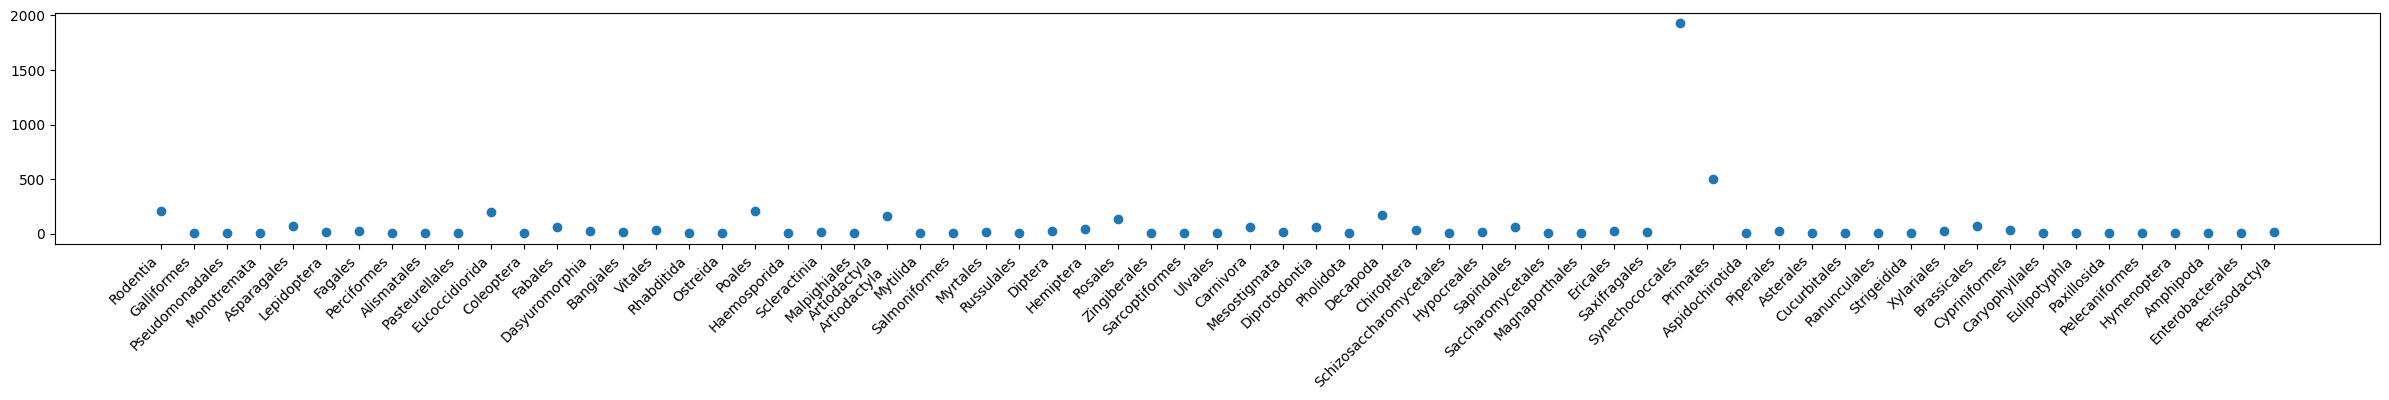

HAS_HOST from STAT:
10 most common:
[('Synechococcales', 943), ('Bacillariales', 715), ('Phaeocystales', 668), ('Primates', 583), ('Carnivora', 408), ('Rodentia', 243), ('Poales', 234), ('Eucoccidiorida', 160), ('Artiodactyla\nArtiodactyla', 158), ('Rosales', 143)]


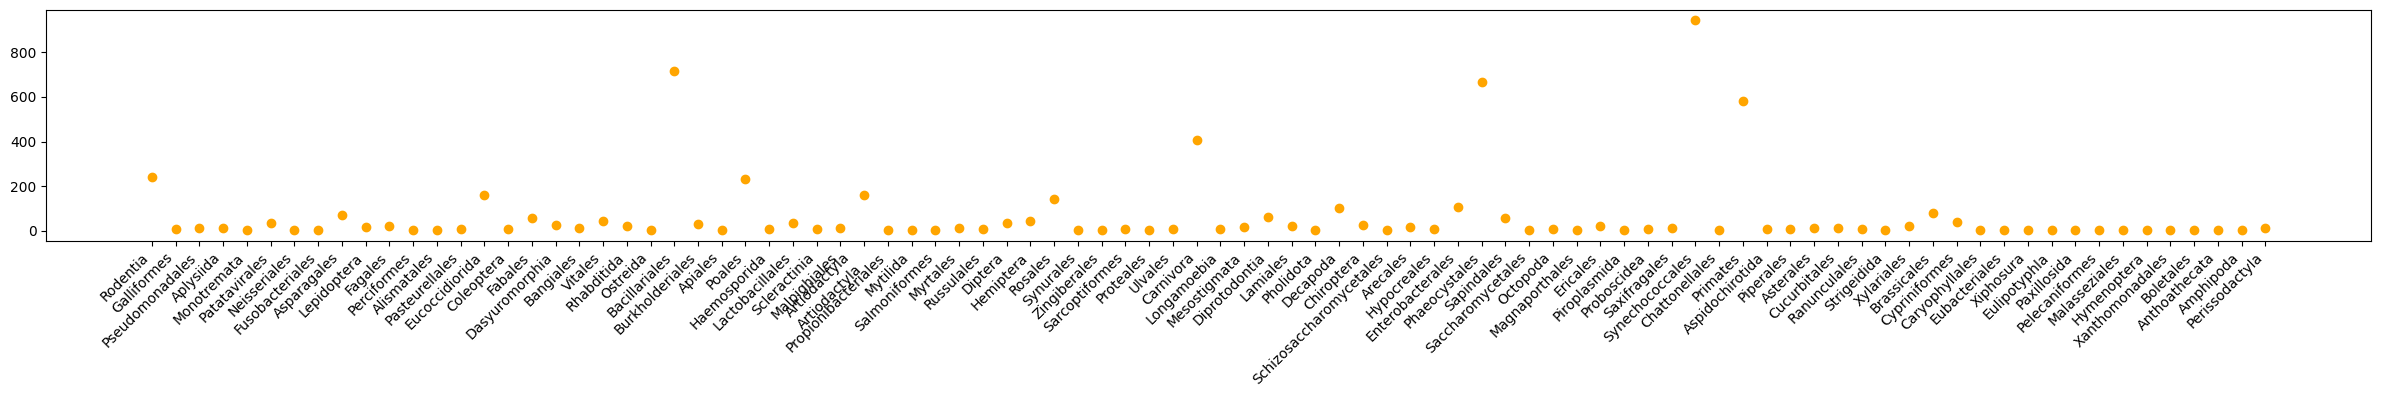

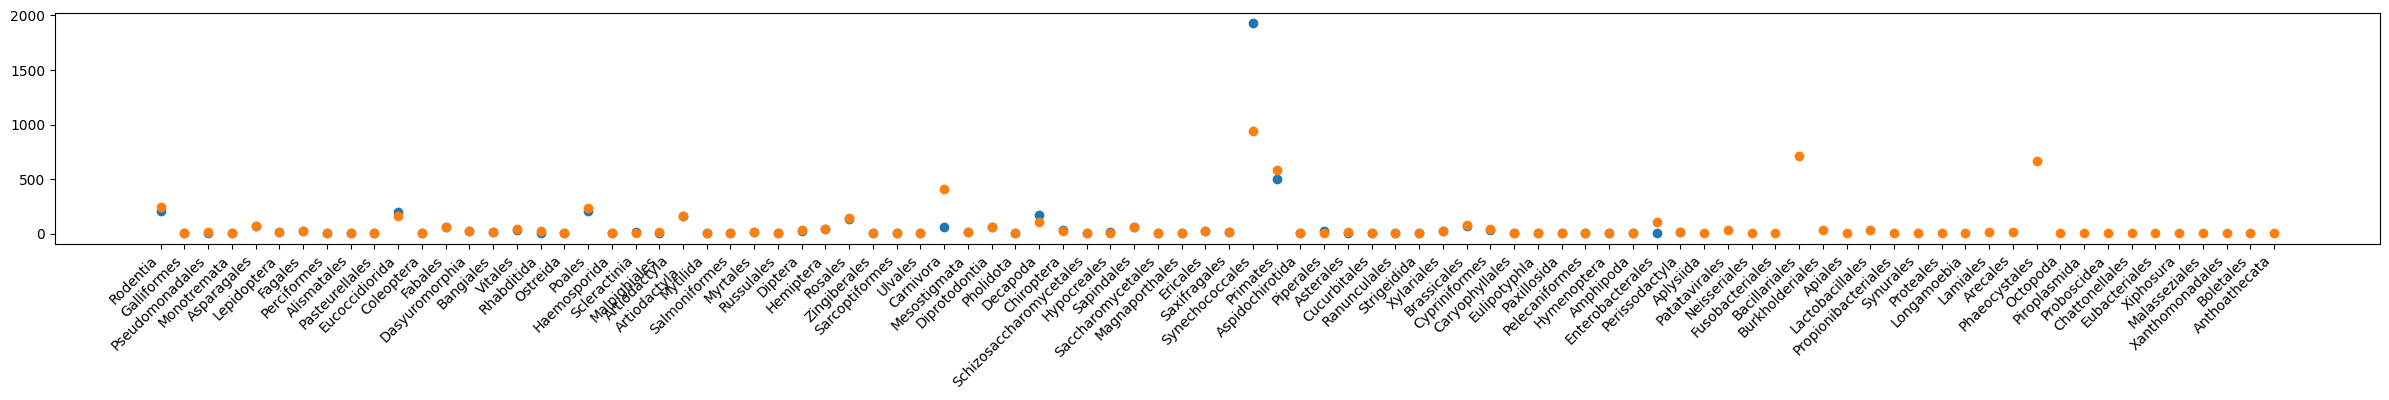

In [19]:
print(len(neo4j_data['has_host_edges'].targetAppId.unique()))
print(len(neo4j_data['has_host_stat_edges'].targetAppId.unique()))

# difference = set(neo4j_data['has_host_stat_edges'].targetAppId.unique()) - set(neo4j_data['has_host_edges'].targetAppId.unique())
# print(difference)


def get_display_label(appId):
    return nodes.loc[nodes['appId'] == str(appId)].displayLabel.to_string(index=False)


names_values = collections.Counter()
for row in neo4j_data['has_host_edges'].itertuples():
    names_values[row.targetAppId] += 1


names_a = [ get_display_label(name) for name in names_values.keys()]
values_a = names_values.values()
print('HAS_HOST Organism labels:')
print('10 most common:')
print([(get_display_label(k), v) for k,v in names_values.most_common(10)])    


plt.figure()
plt.rcParams["figure.figsize"] = (30,3)
plt.scatter(names_a, values_a)
plt.xticks(rotation=45, ha='right')
plt.show()


names_values = collections.Counter()
for row in neo4j_data['has_host_stat_edges'].itertuples():
    names_values[row.targetAppId] += 1


names_b = [ get_display_label(name) for name in names_values.keys()]
values_b = names_values.values()
print('HAS_HOST from STAT:')
print('10 most common:')
print([(get_display_label(k), v) for k,v in names_values.most_common(10)]) 

plt.figure()
plt.rcParams["figure.figsize"] = (30,3)
plt.scatter(names_b, values_b, c='orange')
plt.xticks(rotation=45, ha='right')
plt.show()



plt.figure()
plt.rcParams["figure.figsize"] = (30,3)
plt.scatter(names_a, values_a)
plt.scatter(names_b, values_b)
plt.xticks(rotation=45, ha='right')
plt.show()


# names = [ str(name) for name in names_values.keys() if name in difference]
# values = [ names_values[name] for name in names]
# print(list(zip(names, values)))



In [20]:
g = graphistry.bind()

g = g.bind(
    source='sourceAppId',
    destination='targetAppId',
).edges(relationships)

g = g.bind(node='appId', point_label='displayLabel').nodes(nodes)

params = {
        'play': 2000,
        'menu': True, 
        'info': True,
        'showArrows': True,
        # 'pointSize': 2.0, 
        # 'edgeCurvature': 0.5,
        'edgeOpacity': 0.25, 
        'pointOpacity': 1.0,
        # 'lockedX': False, 'lockedY': False, 'lockedR': False,
        'linLog': True, 
        'compactLayout': True,
        'strongGravity': True,
        'dissuadeHubs': True,
        'edgeInfluence': 5,
        # 'precisionVsSpeed': 0, 'gravity': 1.0, 'scalingRatio': 1.0,
        # 'showLabels': True, 'showLabelOnHover': True,
        # 'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 
        'showLabelPropertiesOnHover': True,
        'pointsOfInterestMax': 15,
      }

g = g.settings(url_params=params)

g = g.encode_point_color(
    'communityColorCodes',
)

g.plot()

# point:fisher IN ("nan", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.8", "0.9")

In [ ]:
print(urllib.parse.urlencode(params))
# https://hub.graphistry.com/graph/graph.html?dataset=5aeb386c894148c28a19e3423ddb7f65&
# https://hub.graphistry.com/graph/graph.html?dataset=5aeb386c894148c28a19e3423ddb7f65&play=2000&menu=True&info=True&showArrows=True&edgeOpacity=0.25&pointOpacity=1.0&linLog=True&compactLayout=True&strongGravity=True&dissuadeHubs=True&edgeInfluence=5&showLabelPropertiesOnHover=True&pointsOfInterestMax=15&splashAfter=false&session=8ad322bd6c3242dca620083ac8e0eb5f

play=2000&menu=True&info=True&showArrows=True&edgeOpacity=0.25&pointOpacity=1.0&linLog=True&compactLayout=True&strongGravity=True&dissuadeHubs=True&edgeInfluence=5&showLabelPropertiesOnHover=True&pointsOfInterestMax=15
